Loading data...
Processing files: ['results/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0230.mat']
/Users/hwenzhang/matlabprojects/nevis/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_spinup.m>@(t)(runoff_max/1000/pd.td/ps.m)*(1-exp(-t/(30*pd.td/ps.t))) 
> In nevis_nodedischarge_python (line 15)
In run (line 112) 
/Users/hwenzhang/matlabprojects/nevis/n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_spinup.m>@(t)moulin_input*(1-exp(-t/(30*pd.td/ps.t)))./(ps.m*ps.x^2) 
> In nevis_nodedischarge_python (line 15)
In run (line 112) 
Data loading completed
Figure saved to ./figures/Fig3_summertime_poster.png
Loading data...
Processing files: ['results/n2d_0m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_0m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage/0120.mat', 'results/

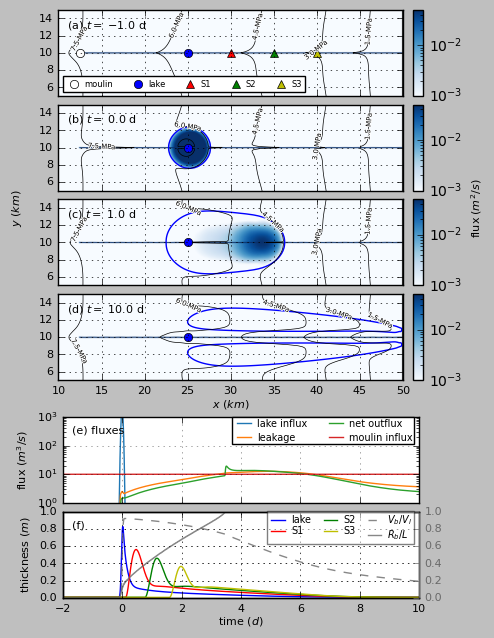

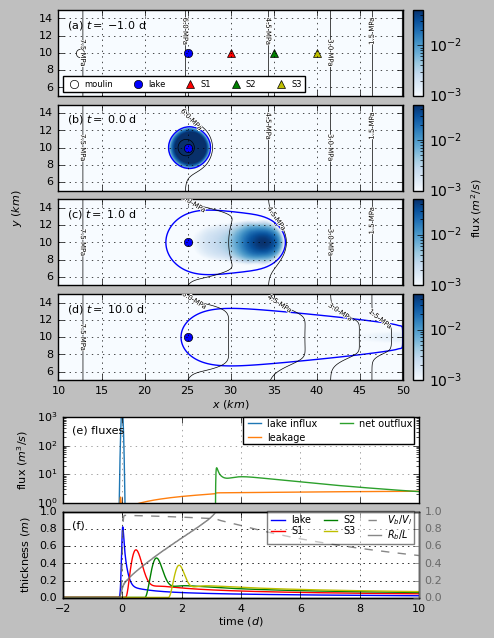

In [2]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
import subprocess

class NevisFig3Plotter:
    """
    A class to generate Figure 3 (summertime) plot for NEVIS simulation data.
    This class packs all the plotting code from the first cell into a single class.
    """
    
    def __init__(self, casename, results_dir='results', matlab_path="/Applications/MATLAB_R2025a.app/bin/matlab"):
        """
        Initialize the plotter with casename and paths.
        
        Args:
            casename: Name of the simulation case
            results_dir: Directory containing results
            matlab_path: Path to MATLAB executable
        """
        self.casename = casename
        self.results_dir = results_dir
        self.matlab_path = matlab_path
        
        # Flag to control data import
        self.SKIP_DATA_IMPORT = False
        self.LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
        
        # -------------------- Parameters for plotting ---------------------------------------------
        okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
                     "#0072B2","#D55E00","#CC79A7","#000000"]
        self.colors = okabe_ito
        self.colors = plt.get_cmap('tab10').colors  

        self.xa = 10 
        self.xb = 50
        self.ya = 5
        self.yb = 15
        self.plot_hb = False
        self.plot_qs = True
        self.h_min = 0  # min water thickness on the color bar (m)
        self.h_max = 0.1  # max water thickness on the color bar (m)
        self.q_min = 1e-3 # min water flux on the color bar (m^2/s)
        self.q_max = 5e-2 # max water flux on the color bar (m^2/s)
        # norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
        self.norm = LogNorm(vmin=self.q_min, vmax=self.q_max)

        self.tdrainge_d = 2.0 * 365 + 20
        self.tmin = self.tdrainge_d - 5
        self.tmax = self.tdrainge_d + 5
        self.tmin_d = self.tmin 
        self.tmax_d = self.tmax
        self.tslice = self.tdrainge_d + np.array([-1, 0, 1, 10])
        
        # Data containers
        self.data_loaded = False
        
    def load_data(self):
        """Load and process all data"""
        if (not self.SKIP_DATA_IMPORT) or (self.LOAD_NEW_DATA):
            print("Loading data...")
            # ------------------------- Import data -----------------------------------

            mat_path = os.path.join(self.results_dir, self.casename, self.casename + '.mat')
            raw = sio.loadmat(mat_path, squeeze_me=True)

            self.tt = raw['tt']
            self.ps = raw['ps']
            self.pp = raw['pp']
            self.oo = raw['oo']
            self.pd = raw['pd']
            self.aa = raw['aa']
            self.gg = raw['gg']

            self.ps_t = np.float64(self.ps['t'])
            self.pd_td = np.float64(self.pd['td'])
            self.ps_hb = np.float64(self.ps['hb'])
            self.ps_h = np.float64(self.ps['h'])
            self.ps_x = np.float64(self.ps['x'])
            self.ps_m = np.float64(self.ps['m'])
            self.ps_S = np.float64(self.ps['S'])
            self.ps_phi = np.float64(self.ps['phi'])
            self.ps_Q0 = np.float64(self.ps['Q0'])
            self.ps_Q = np.float64(self.ps['Q'])
            self.ps_qs = np.float64(self.ps['qs'])
            self.ps_qb = np.float64(self.ps['qb'])
            self.pp_c8 = np.float64(self.pp['c8'])
   
            self.tt_t = np.float64(self.tt['t'])
            self.tt_Qb_in = np.float64(self.tt['Qb_in'])
            self.tt_Qb_dec = np.float64(self.tt['Qb_dec'])
            self.tt_Q_outb = np.float64(self.tt['Q_outb'])
            self.tt_Q_outQ = np.float64(self.tt['Q_outQ'])
            self.tt_Q_outq = np.float64(self.tt['Q_outq'])
            self.tt_E = np.float64(self.tt['E'])

            # --- Compute time vectors -----------------------------------------------
            self.t = (self.ps_t / (24*60*60)) * self.tt_t        # days

            # --- Build derived quantities -------------------------------------------
            self.Q_b_in = np.float64(self.pd['Q_0']) * self.tt_Qb_in
            self.Q_b_dec = self.ps_h * self.ps_x**2 / self.ps_t * self.tt_Qb_dec

            self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
            self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
            self.Q_out_Q = self.ps_Q * self.tt_Q_outQ
            self.Q_out_q = self.ps_Q * self.tt_Q_outq
            self.E = self.ps_m * self.ps_x**2 * self.tt_E

            self.pts_ni = np.int64(self.oo['pts_ni'].item())
            self.phi_0 = self.ps_phi * np.float64(self.aa['phi_0'].item())
            self.pts_phi_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_phi']])
            self.pts_phi_moulin = self.ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_phi']])
            self.pts_hb_lake = self.ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_moulin = self.ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_hb']])
            self.pts_pb_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_pb']])
            self.pts_hc_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hc']])
            self.pts_hs_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hs']])

            # gps elevations
            #     14 15 16 17    18   19
            #.    8  9  10 11    12   13
            #.    2  3  4   5     6   7
            #.  -1km 0 5km 10km 15km 20km
            self.pts_hb_gps1 = self.ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps2 = self.ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps3 = self.ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps4 = self.ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hb']])

            self.pts_hc_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hc']])

            self.pts_hs_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hs']])

            self.N = self.ps_phi * np.float64(self.tt['N'])  # MPa
            self.pts_N_lake = np.float64(self.phi_0[self.pts_ni][0] - self.pts_phi_lake)
            self.pts_N_moulin = np.float64(self.phi_0[self.pts_ni][1] - self.pts_phi_moulin)

            self.V_b = self.ps_x**2 * self.ps_hb * np.float64(self.tt['Vb'])
            self.V_c = self.ps_x * self.ps_S * np.float64(self.tt['S'])
            self.V_s = self.ps_x**2 * self.ps_h * np.float64(self.tt['hs'])
            self.R_b = self.ps_x * np.float64(self.tt['Rb'])

            self.xx = self.ps_x/1e3 * np.float64(self.gg['nx'].item())
            self.yy = self.ps_x/1e3 * np.float64(self.gg['ny'].item())
            self.nI = int(self.gg['nI'].item())
            self.nJ = int(self.gg['nJ'].item())
            self.eI = int(self.gg['eI'].item())
            self.eJ = int(self.gg['eJ'].item())
            self.cI = int(self.gg['cI'].item())
            self.cJ = int(self.gg['cJ'].item())

            self.nmeanx = self.gg['nmeanx'].item()
            self.nmeany = self.gg['nmeany'].item()
            self.nmeans = self.gg['nmeans'].item()
            self.nmeanr = self.gg['nmeanr'].item()
            self.ein = self.gg['ein'].item()
            self.fin = self.gg['fin'].item()
            self.cin = self.gg['cin'].item()
            self.Dx = np.float64(self.gg['Dx'].item())
            self.Dy = np.float64(self.gg['Dy'].item())
            self.Ds = np.float64(self.gg['Ds'].item())
            self.Dr = np.float64(self.gg['Dr'].item())

            # --- get spatial pattern at different times -----------------------------
            tspan = self.ps_t/self.pd_td*self.oo['t_span']
            self.nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in self.tslice])

            # run matlab script to extend the field for times
            filenames = [os.path.join(self.results_dir, self.casename, f"{num:04d}.mat") for num in self.nums]
            print(f"Processing files: {filenames}")
            # save the filenames to a text file
            # Save filenames and casename to a .mat file for MATLAB to load
            filenames_array = np.array(filenames, dtype=object)
            sio.savemat('extend_field.mat', {
                'filenames': filenames_array,
                'casename': self.casename
            })
            # Use MATLAB's -batch option to run the script and auto‐exit when done
            subprocess.run([
                self.matlab_path,
                "-nodisplay",
                "-nosplash",
                "-nodesktop",
                "-batch",
                "run('src/nevis_nodedischarge_python')"
            ], check=True)
            # Clear the temporary .mat file
            os.remove('extend_field.mat')
            
            self.vhb = []
            self.vphi1 = []
            self.vhs = []
            self.vhc = []
            self.vt = []
            self.vqs = []
            self.vqe = []
            self.vqQ = []
            self.vqb = []

            for i in range(len(self.nums)):
                con_path = os.path.join(self.results_dir, self.casename, f"{self.nums[i]:04d}.mat")
                raw_con = sio.loadmat(con_path, squeeze_me=True)
                vv = raw_con['vv']
                vv2 = raw_con['vv2']

                # geometry values
                phi1_val = np.float64(vv['phi'].item())
                hb_val = np.float64(vv['hb'].item())
                hs_val = np.float64(vv['hs'].item())
                pb_val = np.float64(vv['pb'].item())

                Sx_val = self.nmeanx.dot(np.float64(vv['Sx'].item()))
                Sy_val = self.nmeany.dot(np.float64(vv['Sy'].item()))
                Ss_val = self.nmeans.dot(np.float64(vv['Ss'].item()))
                Sr_val = self.nmeanr.dot(np.float64(vv['Sr'].item()))

                self.vphi1.append(np.array(np.reshape(phi1_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vhb.append(np.array(np.reshape(hb_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                vpb = np.array(np.reshape(pb_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                self.vhs.append(np.array(np.reshape(hs_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                vSx = np.array(np.reshape(Sx_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSy = np.array(np.reshape(Sy_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSs = np.array(np.reshape(Ss_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSr = np.array(np.reshape(Sr_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                self.vhc.append(np.reshape(self.pp_c8*(Sx_val*self.Dx + Sy_val*self.Dy + Ss_val*self.Ds + Sr_val*self.Dr)/(self.Dx*self.Dy), (self.nI, self.nJ), order='F'))
                self.vt.append((self.ps_t / self.pd_td) * np.float64(vv['t'].item()))

                # flux values
                qs_val = np.float64(vv2['qs'].item())
                qe_val = np.float64(vv2['qe'].item())
                qQ_val = np.float64(vv2['qQ'].item())
                qb_val = np.float64(vv2['qb'].item())
                self.vqs.append(np.array(np.reshape(qs_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqe.append(np.array(np.reshape(qe_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqQ.append(np.array(np.reshape(qQ_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqb.append(np.array(np.reshape(qb_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
            self.vt = np.array(self.vt, dtype=np.float64)-self.tdrainge_d
            
            self.data_loaded = True
            print("Data loading completed")

    def setup_plotting_style(self):
        """Set up all matplotlib plotting styles"""
        # ================= Plotting setup ======================================
        plt.style.use('classic')
        plt.rc('axes', prop_cycle=cycler('color', self.colors))
        plt.rcParams["figure.dpi"] = 600
        # plt.style.use('classic')
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['mathtext.fontset'] = 'dejavusans'
        plt.rcParams['font.size'] = 8

    def plot_spatial_panel(self, ax, panel_idx, panel_label, add_colorbar=False):
        """Plot a single spatial panel"""
        cmap = plt.cm.Blues
        
        if add_colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.1)
        
        if self.plot_hb:
            pc = ax.pcolormesh(self.xx, self.yy,
                            self.ps_hb * self.vhb[panel_idx] + self.ps_h * self.vhs[panel_idx] + self.ps_h * self.vhc[panel_idx],
                            cmap=cmap, norm=self.norm, shading='gouraud')
            pc.set_edgecolor('face')
        elif self.plot_qs:
            pc = ax.pcolormesh(self.xx, self.yy,
                            self.ps_qs * self.vqs[panel_idx] + self.ps_qb * self.vqb[panel_idx] + self.ps_qs * self.vqQ[panel_idx],
                            cmap=cmap, norm=self.norm, shading='gouraud')
            pc.set_edgecolor('face')
        else:
            print("No valid plot type selected. Please set plot_hb or plot_qs to True.")
            return ax

        # Plot contour lines for the blister alone
        contour_lines = ax.contour(self.xx, self.yy, self.ps_hb * self.vhb[panel_idx], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
        contour_lines_phi = ax.contour(self.xx, self.yy, self.ps_phi/1e6*self.vphi1[panel_idx], colors='k', linewidths=0.5, linestyles='-')
        
        # Add markers and labels only for first panel
        if panel_idx == 0:
            ax.plot(12.5, 10, 'wo', markersize=6, label='moulin')
            ax.plot(25.0, 10, 'bo', markersize=6, label='lake')
            ax.plot(30.0, 10, 'r^', markersize=6, label='S1')
            ax.plot(35.0, 10, 'g^', markersize=6, label='S2')
            ax.plot(40.0, 10, 'y^', markersize=6, label='S3')
            ax.legend(loc='lower left', fontsize=6, frameon=True, handletextpad=0.2, ncol=5, labelspacing=0.2, numpoints=1)
        else:
            ax.plot(25.0, 10, 'bo', markersize=6, label='lake')
        
        if add_colorbar:
            cbar = plt.colorbar(pc, cax=cax, orientation='vertical')
            if panel_idx==1:
                cbar.set_label('thickness$\\;(m)$' if self.plot_hb else 'flux$\\;(m^2/s)$')
                label = cbar.ax.yaxis.label  # for vertical colorbars
                label.set_position((1.05,-0.2))
            cbar.ax.tick_params(labelsize=10)

        ax.text(0.025, 0.9, f'{panel_label} $t=$ ${self.vt[panel_idx]:.1f}$ d', transform=ax.transAxes,
                ha='left', va='top', fontsize=8, clip_on=False, color='black')
        ax.set_xlim(self.xa, self.xb)
        ax.set_ylim(self.ya, self.yb)
        ax.set_aspect('equal')
        ax.grid()
        if panel_idx < 3:
            manual_positions = [(15, 10), (25, 12.5), (35, 12.5), (40, 10), (45, 12.5)]
        else:
            manual_positions = [(15, 10), (25, 12.5), (35, 12.5), (42.5, 12.5), (47.5,12.5)]
        
        labels = ax.clabel(contour_lines_phi, inline=False, fontsize=5, fmt='%1.1f MPa', manual=manual_positions)
        import matplotlib.patheffects as pe
        for txt in labels:
            txt.set_bbox({'facecolor':'none', 'edgecolor':'none', 'pad':0})
            txt.set_path_effects([pe.Stroke(linewidth=1.2, foreground='white'), pe.Normal()])
            txt.set_zorder(10)
        
        return ax

    def generate_figure(self, save_path=None):
        """Generate the complete Figure 3 plot"""
        if not self.data_loaded:
            self.load_data()
            
        self.setup_plotting_style()
        
        fig = plt.figure(figsize=(5, 7), dpi=100)
        gs = gridspec.GridSpec(6, 1, figure=fig, wspace=0.1, hspace=0.1)

        # ================= Panel (a): blister at time a =================
        ax1 = fig.add_subplot(gs[0, 0])
        self.plot_spatial_panel(ax1, 0, '(a)', add_colorbar=True)
        # ax1.set_ylabel('$y~(km)$')
        # remove the x ticks for the top panel
        ax1.tick_params(axis='x', labelbottom=False)

        # ================= Panel (b): blister at time b ================
        ax2 = fig.add_subplot(gs[1, 0])
        self.plot_spatial_panel(ax2, 1, '(b)', add_colorbar=True)
        ax2.set_ylabel('$y~(km)$')
        ax2.yaxis.set_label_coords(-0.1, -0.2)
        ax2.tick_params(axis='x', labelbottom=False)

        # ================= Panel (c): blister at time c ================
        ax3 = fig.add_subplot(gs[2, 0])
        self.plot_spatial_panel(ax3, 2, '(c)', add_colorbar=True)
        # ax3.set_ylabel('$y~(km)$')
        ax3.tick_params(axis='x', labelbottom=False)

        # ================= Panel (d): blister at time d ================
        ax4 = fig.add_subplot(gs[3, 0])
        self.plot_spatial_panel(ax4, 3, '(d)', add_colorbar=True)
        ax4.set_xlabel('$x~(km)$')
        # ax4.set_ylabel('$y~(km)$')
        ax4.xaxis.set_label_coords(0.5, -0.2)

        # ============== Panel (e): Flux (last row: spanning both columns) ==============
        # Panel (e) — combined h/S at the lake (bottom merged)
        ax5 = fig.add_subplot(gs[4, 0])
        ax5.set_visible(False)  # Hide original axes
        pos = gs[4, 0].get_position(fig)
        ax5_pos = [pos.x0+0.04*pos.width, pos.y0-0.04, 0.92*pos.width, pos.height]
        # Create new axes with the calculated positions
        ax5 = fig.add_axes(ax5_pos)

        ax5.plot(self.t-self.tdrainge_d, self.Q_b_in, '-', linewidth=1.0, label='lake influx')
        ax5.plot(self.t-self.tdrainge_d, self.Q_b_dec,'-', linewidth=1.0, label='leakage')
        ax5.plot(self.t-self.tdrainge_d, self.Q_out_b + self.Q_out_Q + self.Q_out_q - self.E, '-', linewidth=1.0, label='net outflux')

        if '10m3s' in self.casename:
            ax5.plot(self.t-self.tdrainge_d, self.E, '-', linewidth=1.0, label='moulin influx')

        ax5.set_yscale('log')
        ax5.tick_params(axis='x', labelbottom=False)

        ax5.xaxis.set_label_coords(0.5, -0.2)

        ax5.set_ylim(1e0, 1e3)
        ax5.set_xlim(-2, 10)
        ax5.set_ylabel('flux$~(m^3/s)$')
        ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
                ha='left', va='top', fontsize=8, clip_on=False)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.0, 1.06), frameon=True, fontsize=7, ncol=2,
                  labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
        ax5.grid(alpha=0.5)

        # ============== Panel (f): total volume and thickness ==============
        ax6 = fig.add_subplot(gs[5, 0])
        ax6.set_visible(False)  # Hide original axes
        pos = gs[5, 0].get_position(fig)

        ax6_pos = [pos.x0+0.04*pos.width, pos.y0-0.04, 0.92*pos.width, pos.height]
        # Create new axes with the calculated positions
        ax6 = fig.add_axes(ax6_pos)

        # ============== Plot thickness ==============
        ax6.plot(self.t-self.tdrainge_d, self.ps_hb*self.pts_hb_lake + self.ps_h*(self.pts_hc_gps1+self.pts_hs_gps1), 'b-', linewidth=1.0, label='lake', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d, self.ps_hb*self.pts_hb_gps2 + self.ps_h*(self.pts_hc_gps2+self.pts_hs_gps2), 'r-', linewidth=1.0, label='S1', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d, self.ps_hb*self.pts_hb_gps3 + self.ps_h*(self.pts_hc_gps3+self.pts_hs_gps3), 'g-', linewidth=1.0, label='S2', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d, self.ps_hb*self.pts_hb_gps4 + self.ps_h*(self.pts_hc_gps4+self.pts_hs_gps4), 'y-', linewidth=1.0, label='S3', alpha=1.0)

        ax6.set_xlim(self.tmin_d+3-self.tdrainge_d, self.tmax_d+10-self.tdrainge_d)
        ax6.set_xlabel('time$~(d)$')
        ax6.xaxis.set_label_coords(0.5, -0.2)
        ax6.set_ylim(0, 1.0)
        ax6.set_xlim(-2, 10)
        ax6.set_ylabel('thickness$~(m)$')
        ax6.text(0.025, 0.9, '(f)', transform=ax6.transAxes,
                ha='left', va='top', fontsize=8, clip_on=False)
        ax6.grid(alpha=1.0)

        # ============== Plot volume ==============
        ax6_twin = ax6.twinx()
        ax6_twin.plot(self.t-self.tdrainge_d, self.V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
        ax6_twin.plot(self.t-self.tdrainge_d, self.R_b/2.5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

        ax6_twin.set_xlabel('time$~(d)$')
        # ax6_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
        ax6_twin.set_ylim(0, 1.0)
        ax6_twin.tick_params(axis='y', labelsize=8)
        ax6_twin.grid(alpha=0.5)
        # make axis and label blue
        ax6_twin.spines['right'].set_color('dimgray')
        ax6_twin.yaxis.label.set_color('dimgray')
        ax6_twin.tick_params(axis='y', colors='dimgray')

        # combine legend entries from ax6 and its twin
        handles1, labels1 = ax6.get_legend_handles_labels()
        handles2, labels2 = ax6_twin.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right',
            bbox_to_anchor=(1.0, 1.06), fontsize=7, ncol=3,
            labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
            frameon=True, framealpha=0.5)

        if save_path:
            fig.savefig(save_path, dpi=600, transparent=False, bbox_inches='tight', pad_inches=0.1)
            print(f"Figure saved to {save_path}")
        
        return fig
    
    def generate_cross_section_figure(self, save_path=None):
        """Generate the cross-section figure (Figure 4)"""
        tslice_cross = self.tdrainge_d + np.array([-1, 0, 1, 2, 4])
        
        if not self.data_loaded or not np.array_equal(self.tslice, tslice_cross):
            self.tslice = tslice_cross
            self.data_loaded = False
            self.load_data()
            
        self.setup_plotting_style()
        
        # ================= Plotting setup ======================================
        fig = plt.figure(figsize=(4.5, 3), dpi=100)
        gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], wspace=0.05, hspace=0.3)

        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[1, 0])
        cax = plt.subplot(gs[:, 1])

        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        poscax = cax.get_position()

        vertical_gap = -0.008
        # Set ax2's bottom to be just below ax1's top
        new_pos2_bottom = pos1.y0 - 0.8*pos2.height - vertical_gap
        ax2.set_position([pos2.x0, new_pos2_bottom, pos2.width, 0.8*pos2.height])
        cax.set_position([poscax.x0, pos2.y0+0.17, poscax.width, pos1.y0+ pos1.height - pos2.y0 - 0.2])

        plt.rcParams["figure.dpi"] = 100
        plt.rcParams['axes.linewidth'] = 0.5
        plt.rcParams['lines.linewidth'] = 0.6
        plt.rcParams['grid.linewidth'] = 0.3
        plt.rcParams['axes.labelsize'] = 7
        plt.rcParams['xtick.labelsize'] = 7
        plt.rcParams['ytick.labelsize'] = 7

        cmap = plt.cm.plasma
        norm = PowerNorm(gamma=1.0, vmin=np.min(self.vt), vmax=np.max(self.vt))
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])

        # ================= Panel (a): blister profile (plan view) =================
        for i in range(len(self.nums)):
            color_i = cmap(norm(self.vt[i]))
            CS = ax1.contour(self.xx, self.yy, self.ps_hb * self.vhb[i], levels=[0.01], colors=[color_i])

        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_label('time $(d)$')

        ax1.set_xlim(10, 50)
        ax1.set_ylim(5, 15)
        ax1.tick_params(axis='x', labelbottom=False)  # hide x ticks for top panel
        ax1.set_ylabel('$y~(km)$')
        ax1.set_aspect('equal', adjustable='box')
        ax1.text(0.025, 0.8, '(a) plan-view', transform=ax1.transAxes,
                 ha='left', va='bottom', fontsize=8, clip_on=False)
        ax1.grid(alpha=0.5)

        # ================= Panel (b): blister profile (cross section) =================
        p = []
        for i in range(len(self.nums)):
            color_i = cmap(norm(self.vt[i]))
            p.append(ax2.plot(self.xx[:,0], self.ps_hb * self.vhb[i][:,self.nJ//2], color=color_i))  # Plot each time step

        ax2.set_xlabel('$x~(km)$')
        ax2.xaxis.set_label_coords(0.5, -0.175)
        ax2.set_ylabel('thickness$~(m)$')
        ax2.set_xlim(10, 50)
        ax2.set_ylim(0, 0.75)
        ax2.text(0.025, 0.9, '(b) cross-section', transform=ax2.transAxes,
                 ha='left', va='top', fontsize=8, clip_on=False, color='black')
        ax2.grid(alpha=0.5)

        fig.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for colorbar

        if save_path:
            fig.savefig(save_path, dpi=600, transparent=False, bbox_inches='tight', pad_inches=0.1)
            print(f"Cross-section figure saved to {save_path}")

        return fig
    
# Example usage:
if __name__ == "__main__":

    plotter = NevisFig3Plotter('n2d_10m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage')
    fig1 = plotter.generate_figure(save_path='./figures/Fig3_summertime_poster.png')

    plotter = NevisFig3Plotter('n2d_0m3s_kappa1e_10_mu1e01_hbreg5e_3_V1e7_drainage')
    fig2 = plotter.generate_figure(save_path='./figures/Fig2_wintertime_poster.png')
    # Show the plot
    plt.show()

Analyzing case: n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage, Average Speed: 4.0946 m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e6_drainage, Average Speed: 1.3314 m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage, Average Speed: 0.1700 m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e6_drainage, Average Speed: 0.0194 m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage, Average Speed: 0.0020 m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e6_drainage
Processing: n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e6_drainage, Average Speed: nan m/s
Analyzing case: n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e6_drainage
P

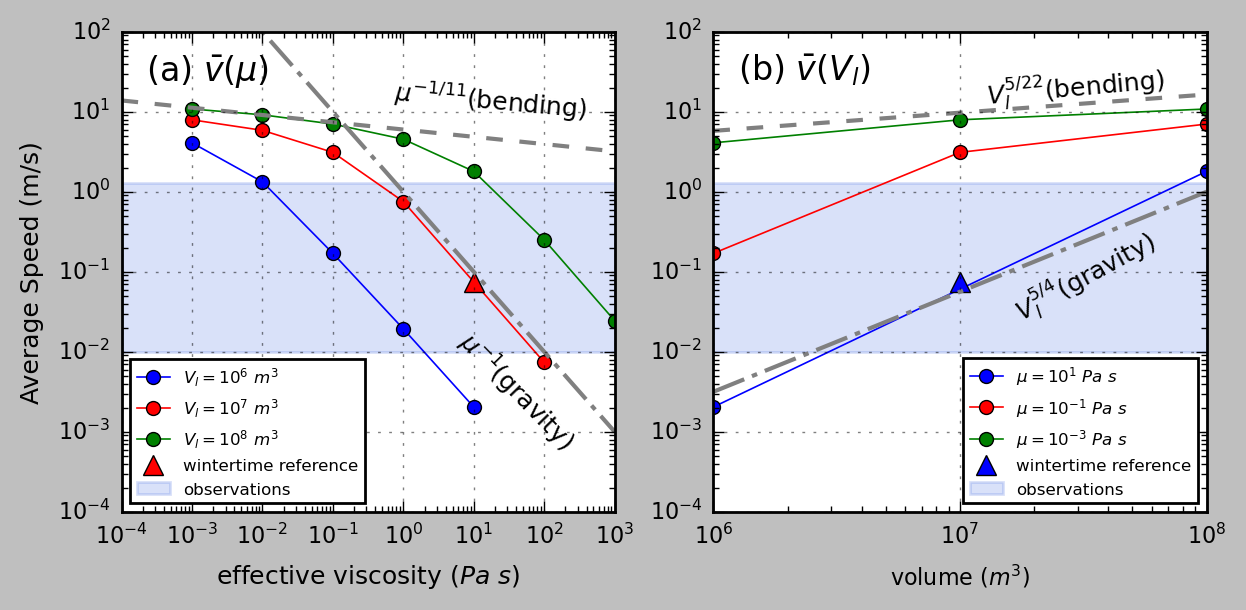

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio

class NevisCaseAnalyzer:
    """
    A class for loading and analyzing NEVIS .mat result files.

    This class can process one or more casenames, calculate the front propagation speed
    for each case, and store the results for later use.
    """
    def __init__(self, results_dir='results'):
        """
        Initialize the analyzer.

        Args:
            results_dir (str): Root directory containing casename result folders.
        """
        self.results_dir = results_dir
        self.results = {}

    def _load_and_process_case(self, casename):
        """
        Load and process data for a single case.
        """
        mat_path = os.path.join(self.results_dir, casename, f"{casename}.mat")
        try:
            raw = sio.loadmat(mat_path, squeeze_me=True)
        except FileNotFoundError:
            print(f"Warning: File not found {mat_path}, skipping this case.")
            return None

        # Extract data
        tt = raw['tt']
        ps = raw['ps']
        
        # Type conversion
        ps_x = np.float64(ps['x'])
        ps_t = np.float64(ps['t'])
        
        # Calculate derived quantities
        R_b = ps_x * np.float64(tt['Rb'])
        t = (ps_t / (24 * 60 * 60)) * np.float64(tt['t'])

        # Core analysis logic
        R_b = np.where(R_b > 25e3, 0.0, R_b)  # Filter outliers
        if not np.any(R_b > 0):
            print(f"Warning: In {casename}, R_b has no positive values, unable to calculate speed.")
            return None
            
        R_max = np.max(R_b)
        
        # Find start and end indices
        # start_indices = np.where(t > tdrainge_d)[0]
        start_indices = np.where((R_b > 0.2 * R_max) & (R_b < 0.3 * R_max))[0]
        end_indices = np.where((R_b > 0.8 * R_max) & (R_b < R_max))[0]

        if len(start_indices) == 0 or len(end_indices) == 0:
            print(f"Warning: Unable to determine start or end points in {casename}.")
            return None
            
        idx_start = start_indices[0]
        idx_end = end_indices[0]

        # Calculate average speed
        delta_R = R_b[idx_end] - R_b[idx_start]
        delta_t = t[idx_end] - t[idx_start]
        
        if delta_t == 0:
            print(f"Warning: Time difference is zero in {casename}, unable to calculate speed.")
            return None

        avg_speed = (delta_R / delta_t) / (24 * 3600)  # m/s
        if avg_speed < 1e-3 or avg_speed > 1e2:
            avg_speed = np.nan  # Set to NaN if speed is too low
        print(f"Processing: {casename}, Average Speed: {avg_speed:.4f} m/s")
        return avg_speed

    def run_analysis(self, casenames):
        """
        Run analysis for a list of casenames.

        Args:
            casenames (list): List of casename strings to analyze.
        
        Returns:
            list: List of calculated average speeds.
        """
        avg_speeds = []
        for casename in casenames:
            print(f"Analyzing case: {casename}")
            speed = self._load_and_process_case(casename)
            if speed is not None:
                avg_speeds.append(speed)
        
        # Store results in the instance
        self.results['avg_speeds'] = avg_speeds
        return np.array(avg_speeds)


fontsize_panel = 9

casenames1 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e6_drainage']

casenames2 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e7_drainage']

casenames3 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e8_drainage']

fig,ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# vmu = np.array([1e-4, 1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
vmu = np.array([1e-3, 1e-2,1e-1, 1e0, 1e1, 1e2, 1e3])
# vmu = np.array([1e3])
t_start = []
t_end = []

ax = plt.subplot(121)
analyzer = NevisCaseAnalyzer()
avg_speed1 = analyzer.run_analysis(casenames1)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

mask = np.arange(len(vmu)) != 4
ax.plot(vmu, avg_speed1, marker='o', markersize=5, linestyle='-', color='b', label=r'$V_l=10^6~m^3$')
ax.plot(vmu[mask], avg_speed2[mask], marker='o', markersize=5, linestyle='-', color='r', label=r'$V_l=10^7~m^3$')
ax.plot(vmu, avg_speed3, marker='o', markersize=5, linestyle='-', color='g', label=r'$V_l=10^8~m^3$')
ax.plot(vmu[4], avg_speed2[4], marker='^', markersize=7, linestyle='None', color='red', label='wintertime reference')

# plot theoretical lines
vmutheory = np.linspace(1e-4, 1e3, 10)
ax.plot(vmutheory, 6e0*vmutheory**(-1/11), linewidth=1.5, linestyle='--', color='gray') 
ax.plot(vmutheory, vmutheory**(-1), linewidth=1.5, linestyle=(0, (12, 3, 2, 3)), color='gray')
ax.text(0.55,0.82, r'$\mu^{-1/11}$(bending)', fontsize=fontsize_panel, color='black', transform=ax.transAxes, rotation=-180/np.pi*1/11)
ax.text(0.67,0.13, r'$\mu^{-1}$(gravity)', fontsize=fontsize_panel, color='black', transform=ax.transAxes, rotation=-0.8*180/np.pi)

ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('effective viscosity$~(Pa~s)$',fontsize=fontsize_panel)
ax.set_ylabel('Average Speed (m/s)',fontsize=fontsize_panel)
ax.tick_params(axis='both', labelsize=fontsize_panel-1)
ax.set_ylim(1e-4, 1e2)
ax.set_xlim(1e-4, 1e3)
ax.text(0.05, 0.9, r'(a) $\bar{v}\left(\mu\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='lower left', fontsize=fontsize_panel-3, numpoints=1)

# ================= Panel (b): speed vs volume =================
ax = plt.subplot(122)
vVl = np.array([1e6, 1e7, 1e8])

casenames1 = ['n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e8_drainage']

casenames2 = ['n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e8_drainage']

casenames3 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e8_drainage']

avg_speed1 = analyzer.run_analysis(casenames1)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

mask = np.arange(len(vVl)) != 1
ax.plot(vVl[mask], avg_speed2[mask], marker='o', markersize=5, linestyle='-', color='b', label=r'$\mu=10^{1}~Pa~s$')
ax.plot(vVl, avg_speed1, marker='o', markersize=5, linestyle='-', color='r', label=r'$\mu=10^{-1}~Pa~s$')
ax.plot(vVl, avg_speed3, marker='o', markersize=5, linestyle='-', color='g', label=r'$\mu=10^{-3}~Pa~s$')
ax.plot(vVl[1], avg_speed2[1], marker='^', markersize=7, linestyle='None', color='blue', label='wintertime reference')

ax.plot(vVl, 1e-10*vVl**(5/4), linewidth=1.5, linestyle=(0, (12, 3, 2, 3)), color='gray')
ax.text(0.60,0.40, r'$V_l^{5/4}$(gravity)', fontsize=fontsize_panel, color='black', transform=ax.transAxes, rotation=180/np.pi*1/2)
ax.plot(vVl, 0.25e0*vVl**(5/22), linewidth=1.5, linestyle='--', color='gray')
ax.text(0.55,0.85, r'$V_l^{5/22}$(bending)', fontsize=fontsize_panel, color='black', transform=ax.transAxes, rotation=180/np.pi*2/22)

ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('volume$~(m^3)$')
# ax.set_ylabel('Average Speed (m/s)')
ax.set_xlim(1e6, 1e8)
ax.set_ylim(1e-4, 1e2)
ax.text(0.05, 0.9, r'(b) $\bar{v}\left(V_l\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='lower right', fontsize=fontsize_panel-3, numpoints=1)
fig.savefig(
    './figures/Fig5_velocity_poster.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()

Processing: n2d_0m3s_kappa1e_15_mu1e3_hbreg5e_3_V1e7_drainage, Start time: 750.15 d, End time: 781.00 d
  Q_outb does not increase significantly in this case.
  Volume at start: 9987775.55 m^3
  Volume at end: 9987273.78 m^3
  Volume difference: -501.77 m^3 over 30.85 d
Processing: n2d_0m3s_kappa1e_14_mu1e3_hbreg5e_3_V1e7_drainage, Start time: 750.15 d, End time: 781.00 d
  Q_outb does not increase significantly in this case.
  Volume at start: 9987768.95 m^3
  Volume at end: 9987027.98 m^3
  Volume difference: -740.97 m^3 over 30.85 d
Processing: n2d_0m3s_kappa1e_13_mu1e3_hbreg5e_3_V1e7_drainage, Start time: 750.14 d, End time: 781.00 d
  Q_outb does not increase significantly in this case.
  Volume at start: 9987705.42 m^3
  Volume at end: 9984573.33 m^3
  Volume difference: -3132.08 m^3 over 30.86 d
Processing: n2d_0m3s_kappa1e_12_mu1e3_hbreg5e_3_V1e7_drainage, Start time: 750.13 d, End time: 781.00 d
  Q_outb does not increase significantly in this case.
  Volume at start: 9987103.

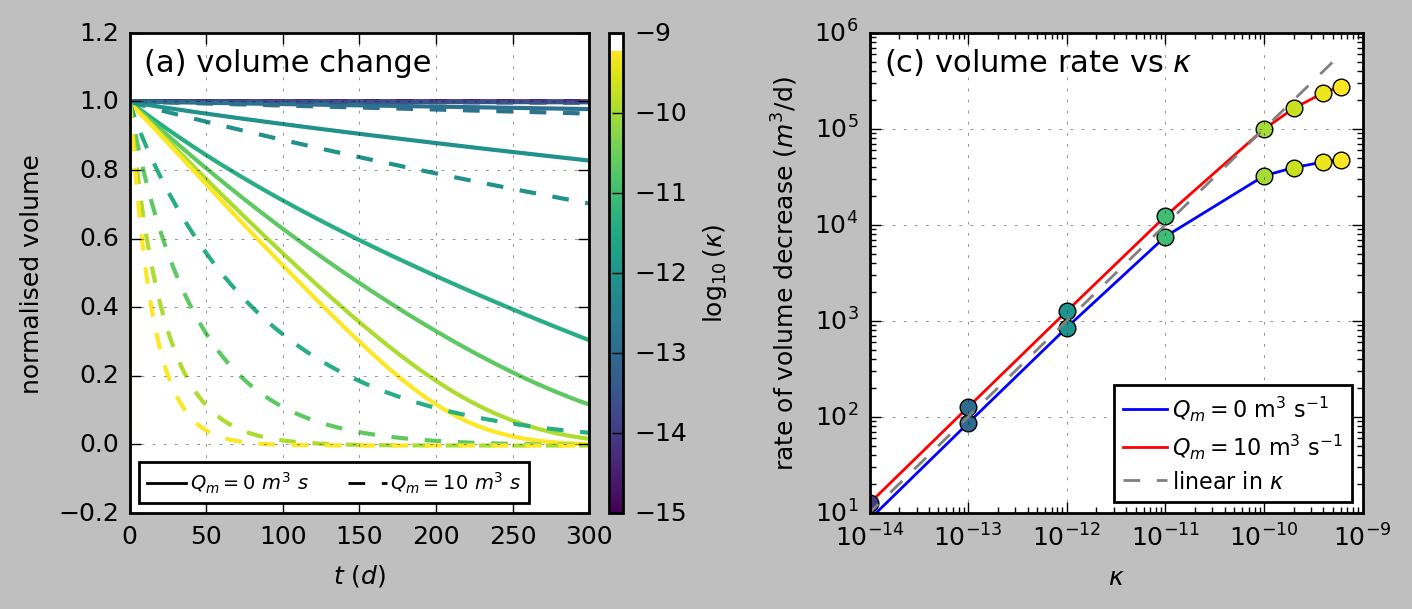

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio
from mpl_toolkits.axes_grid1 import make_axes_locatable

casenames = ['n2d_0m3s_kappa6e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
              'n2d_0m3s_kappa4e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
              'n2d_0m3s_kappa2e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_10_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_14_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_15_mu1e3_hbreg5e_3_V1e7_drainage']
casenames = casenames[::-1]  # reverse the order

casenames2 = ['n2d_10m3s_kappa6e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
              'n2d_10m3s_kappa4e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
              'n2d_10m3s_kappa2e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_10_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_11_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_12_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_13_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_14_mu1e03_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_15_mu1e03_hbreg5e_3_V1e7_drainage']
casenames2 = casenames2[::-1]  # reverse the order


fig, ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 8  #
plt.rcParams['xtick.labelsize'] = 8 #
plt.rcParams['ytick.labelsize'] = 8 #
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

ax1 = plt.subplot(121)

vkappa = np.array([1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 2e-10, 4e-10, 6e-10])
t_start = []
t_end = []
fontsize_panel = 9


class VolumeAnalysis:
    def __init__(self, casenames, vkappa):
        self.casenames = casenames
        self.vkappa = vkappa
        self.avg_dVdt = []
        # set up a color scheme
        self.colors = plt.cm.viridis(np.linspace(0, 1, len(casenames)))

    def process_case(self, casename, vkappa_value, i, ax1):
        mat_path = os.path.join('results', casename, casename + '.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)

        tt = raw['tt']
        ps = raw['ps']

        ps_hb = np.float64(ps['hb'])
        ps_x = np.float64(ps['x'])
        ps_S = np.float64(ps['S'])
        ps_h = np.float64(ps['h'])
        ps_t = np.float64(ps['t'])

        V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
        dVdt = np.gradient(V_b, ps_t*(24*60*60))  # velocity in m/s

        tt_Q_outb = np.float64(tt['Q_outb'])
        t = (ps_t / (24*60*60)) * np.float64(tt['t'])

        idx_start = np.where((V_b > 0.99 * np.max(V_b)) & (dVdt < 0))[0][0]
        # idx_start = np.where(t > 750.25)[0][0]
        idx_end = np.where(t > t[idx_start] + 30)[0][0]
        print(f"Processing: {casename}, Start time: {t[idx_start]:.2f} d, End time: {t[idx_end]:.2f} d")
        # find the time when Q_outb starts to increase significantly
        idx_out = np.where(tt_Q_outb > 1e-6)[0]
        if idx_out.size > 0:
            print(f"  Q_outb starts to increase at t = {t[idx_out[0]]:.2f} d")
        else:
            print(f"  Q_outb does not increase significantly in this case.")

        Vb0 = V_b[idx_start]
        # Vb0 = 1e7
        Vbend = V_b[idx_end]
        print(f"  Volume at start: {Vb0:.2f} m^3")
        print(f"  Volume at end: {Vbend:.2f} m^3")
        print(f"  Volume difference: {Vbend - Vb0:.2f} m^3 over {t[idx_end] - t[idx_start]:.2f} d")
        V_b[idx_start]= np.nan
        dVdt0 = (V_b[1]-V_b[0])/(t[1]-t[0])
        if casename.startswith('n2d_0m3s'):
            self.avg_dVdt.append((Vbend - Vb0) / (t[idx_end] - t[idx_start])-dVdt0)
        else:
            self.avg_dVdt.append((Vbend - Vb0) / (t[idx_end] - t[idx_start])-dVdt0)
        

        exp = int(np.log10(vkappa_value))
        if casename.startswith('n2d_0m3s'):
            ax1.plot(t-t[idx_start], V_b/Vb0 - 0*dVdt0*(t-t[idx_start])/Vb0, linewidth=1.5, linestyle='-', color=self.colors[i])
            # label=rf'$Q_m=0~m^3~s$'
        else:
            ax1.plot(t-t[idx_start], V_b/Vb0 - 0*dVdt0*(t-t[idx_start])/Vb0, linewidth=1.5, linestyle='--', color=self.colors[i])
            # label=rf'$Q_m=10~m^3~s$'


    def analyze(self, ax1):
        for i, casename in enumerate(self.casenames):
            self.process_case(casename, self.vkappa[i], i, ax1)

# Instantiate and use the class
volume_analysis = VolumeAnalysis(casenames, vkappa)
volume_analysis.analyze(ax1)
avg_dVdt1 = volume_analysis.avg_dVdt
volume_analysis = VolumeAnalysis(casenames2, vkappa)
volume_analysis.analyze(ax1)
avg_dVdt2 = volume_analysis.avg_dVdt
# create two invisible lines to show legend
ax1.plot([], [], color='k', linewidth=1.0, linestyle='-', label=rf'$Q_m=0~m^3~s$')
ax1.plot([], [], color='k', linewidth=1.0, linestyle='--', label=rf'$Q_m=10~m^3~s$')

# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim(0, 300.0)
ax1.set_ylim(-0.2, 1.2)
ax1.set_xlabel(r'$t~(d)$',fontsize = fontsize_panel)
ax1.set_ylabel(r'normalised volume',fontsize = fontsize_panel)
ax1.tick_params(axis='both', labelsize=fontsize_panel) 
# ax1.set_yticks(np.arange(0.7, 1.05, 0.1))
# ax1.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0.7, 1.05, 0.1)])
ax1.text(0.03, 0.92, r'(a) volume change', fontsize = fontsize_panel+2, transform=ax1.transAxes)
ax1.legend(loc='lower left', fontsize=fontsize_panel-2, frameon=True, handletextpad=0.2, ncol=2, labelspacing=0.2, numpoints=1)
ax1.grid(alpha=0.5)

# add a colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.log10(vkappa.min()), vmax=np.log10(vkappa.max())))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax1)
cbar.set_label(r'$\log_{10}(\kappa)$', fontsize=fontsize_panel)
cbar.ax.tick_params(labelsize=fontsize_panel)
cbar.set_ticks(np.arange(np.floor(np.log10(vkappa.min())), np.ceil(np.log10(vkappa.max())) + 1, 1))

# ================= Panel (b): speed vs volume =================
ax2 = plt.subplot(122)
# move ax2 to the right
ax2.set_visible(False)  # Hide original axes
# Get positions of ax2
pos_ax2  = ax2.get_position()
ax2_width = pos_ax2.x1 - pos_ax2.x0
ax2_height = pos_ax2.y1 - pos_ax2.y0
ax2_pos = [pos_ax2.x0+0.30*ax2_width, pos_ax2.y0, ax2_width, ax2_height]
ax2 = fig.add_axes(ax2_pos)

avg_dVdt1 = np.array(avg_dVdt1)
avg_dVdt2 = np.array(avg_dVdt2)

import matplotlib.cm as cm
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.log10(vkappa.min()), vmax=np.log10(vkappa.max()))
ax2.plot(vkappa, -avg_dVdt1, linestyle='-', linewidth=1.0, 
         color='blue', label=r'$Q_m=0~\text{m}^3~\text{s}^{-1}$')
ax2.plot(vkappa, -avg_dVdt2, linestyle='-', linewidth=1.0, 
         color='red', label=r'$Q_m=10~\text{m}^3~\text{s}^{-1}$')
for i in range(len(vkappa)):
    color_i = cmap(norm(np.log10(vkappa[i])))
    ax2.plot(vkappa[i], -avg_dVdt1[i], marker='o', linestyle='', 
             markersize=6, color=color_i)
    ax2.plot(vkappa[i], -avg_dVdt2[i], marker='o', linestyle='', 
             markersize=6, color=color_i)

ax2.plot(vkappa, 1e15*vkappa**(1), linestyle='--', linewidth=1.0, color='gray', label=r'linear in $\kappa$')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-14, 1e-9)
ax2.set_ylim(1e1, 1e6)
ax2.set_xlabel(r'$\kappa$',fontsize = fontsize_panel)
# ax2.set_ylabel(r'$-\langle {dV/dt} \rangle$ ($m^3$/d)',fontsize = fontsize_panel)
ax2.set_ylabel(r'rate of volume decrease ($m^3$/d)',fontsize = fontsize_panel)
ax2.tick_params(axis='both', labelsize=fontsize_panel) 
ax2.text(0.03, 0.92, r'(c) volume rate vs $\kappa$', fontsize = fontsize_panel+2, transform=ax2.transAxes)
ax2.legend(loc='lower right', fontsize=fontsize_panel-1, frameon=True, handletextpad=0.2, ncol=1, labelspacing=0.4, numpoints=1)
ax2.grid(alpha=0.5)

fig.savefig(
    './figures/Fig6_volume_poster.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()

Loading data...
Processing files: ['results/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage/0130.mat', 'results/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage/0232.mat', 'results/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage/0250.mat', 'results/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage/0265.mat']
/Users/hwenzhang/matlabprojects/nevis/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage.m>@(t)0*runoff(((t*ps.t)/pd.td),runoff_2010_nevis140)./ps.m 
> In nevis_nodedischarge_python (line 15)
In run (line 112) 
/Users/hwenzhang/matlabprojects/nevis/n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage.m>@(t)0 
> In nevis_nodedischarge_python (line 15)
In run (line 112) 
Data loading completed


/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_70999/2470768794.py:328: UserWarning: The following kwargs were not used by contour: 'label'
  contour_lines = ax.contour(self.xx, self.yy, self.ps_phi/1e6*self.vphi1[panel_idx],


Figure saved to ./figures/Fig7_regional_poster.png


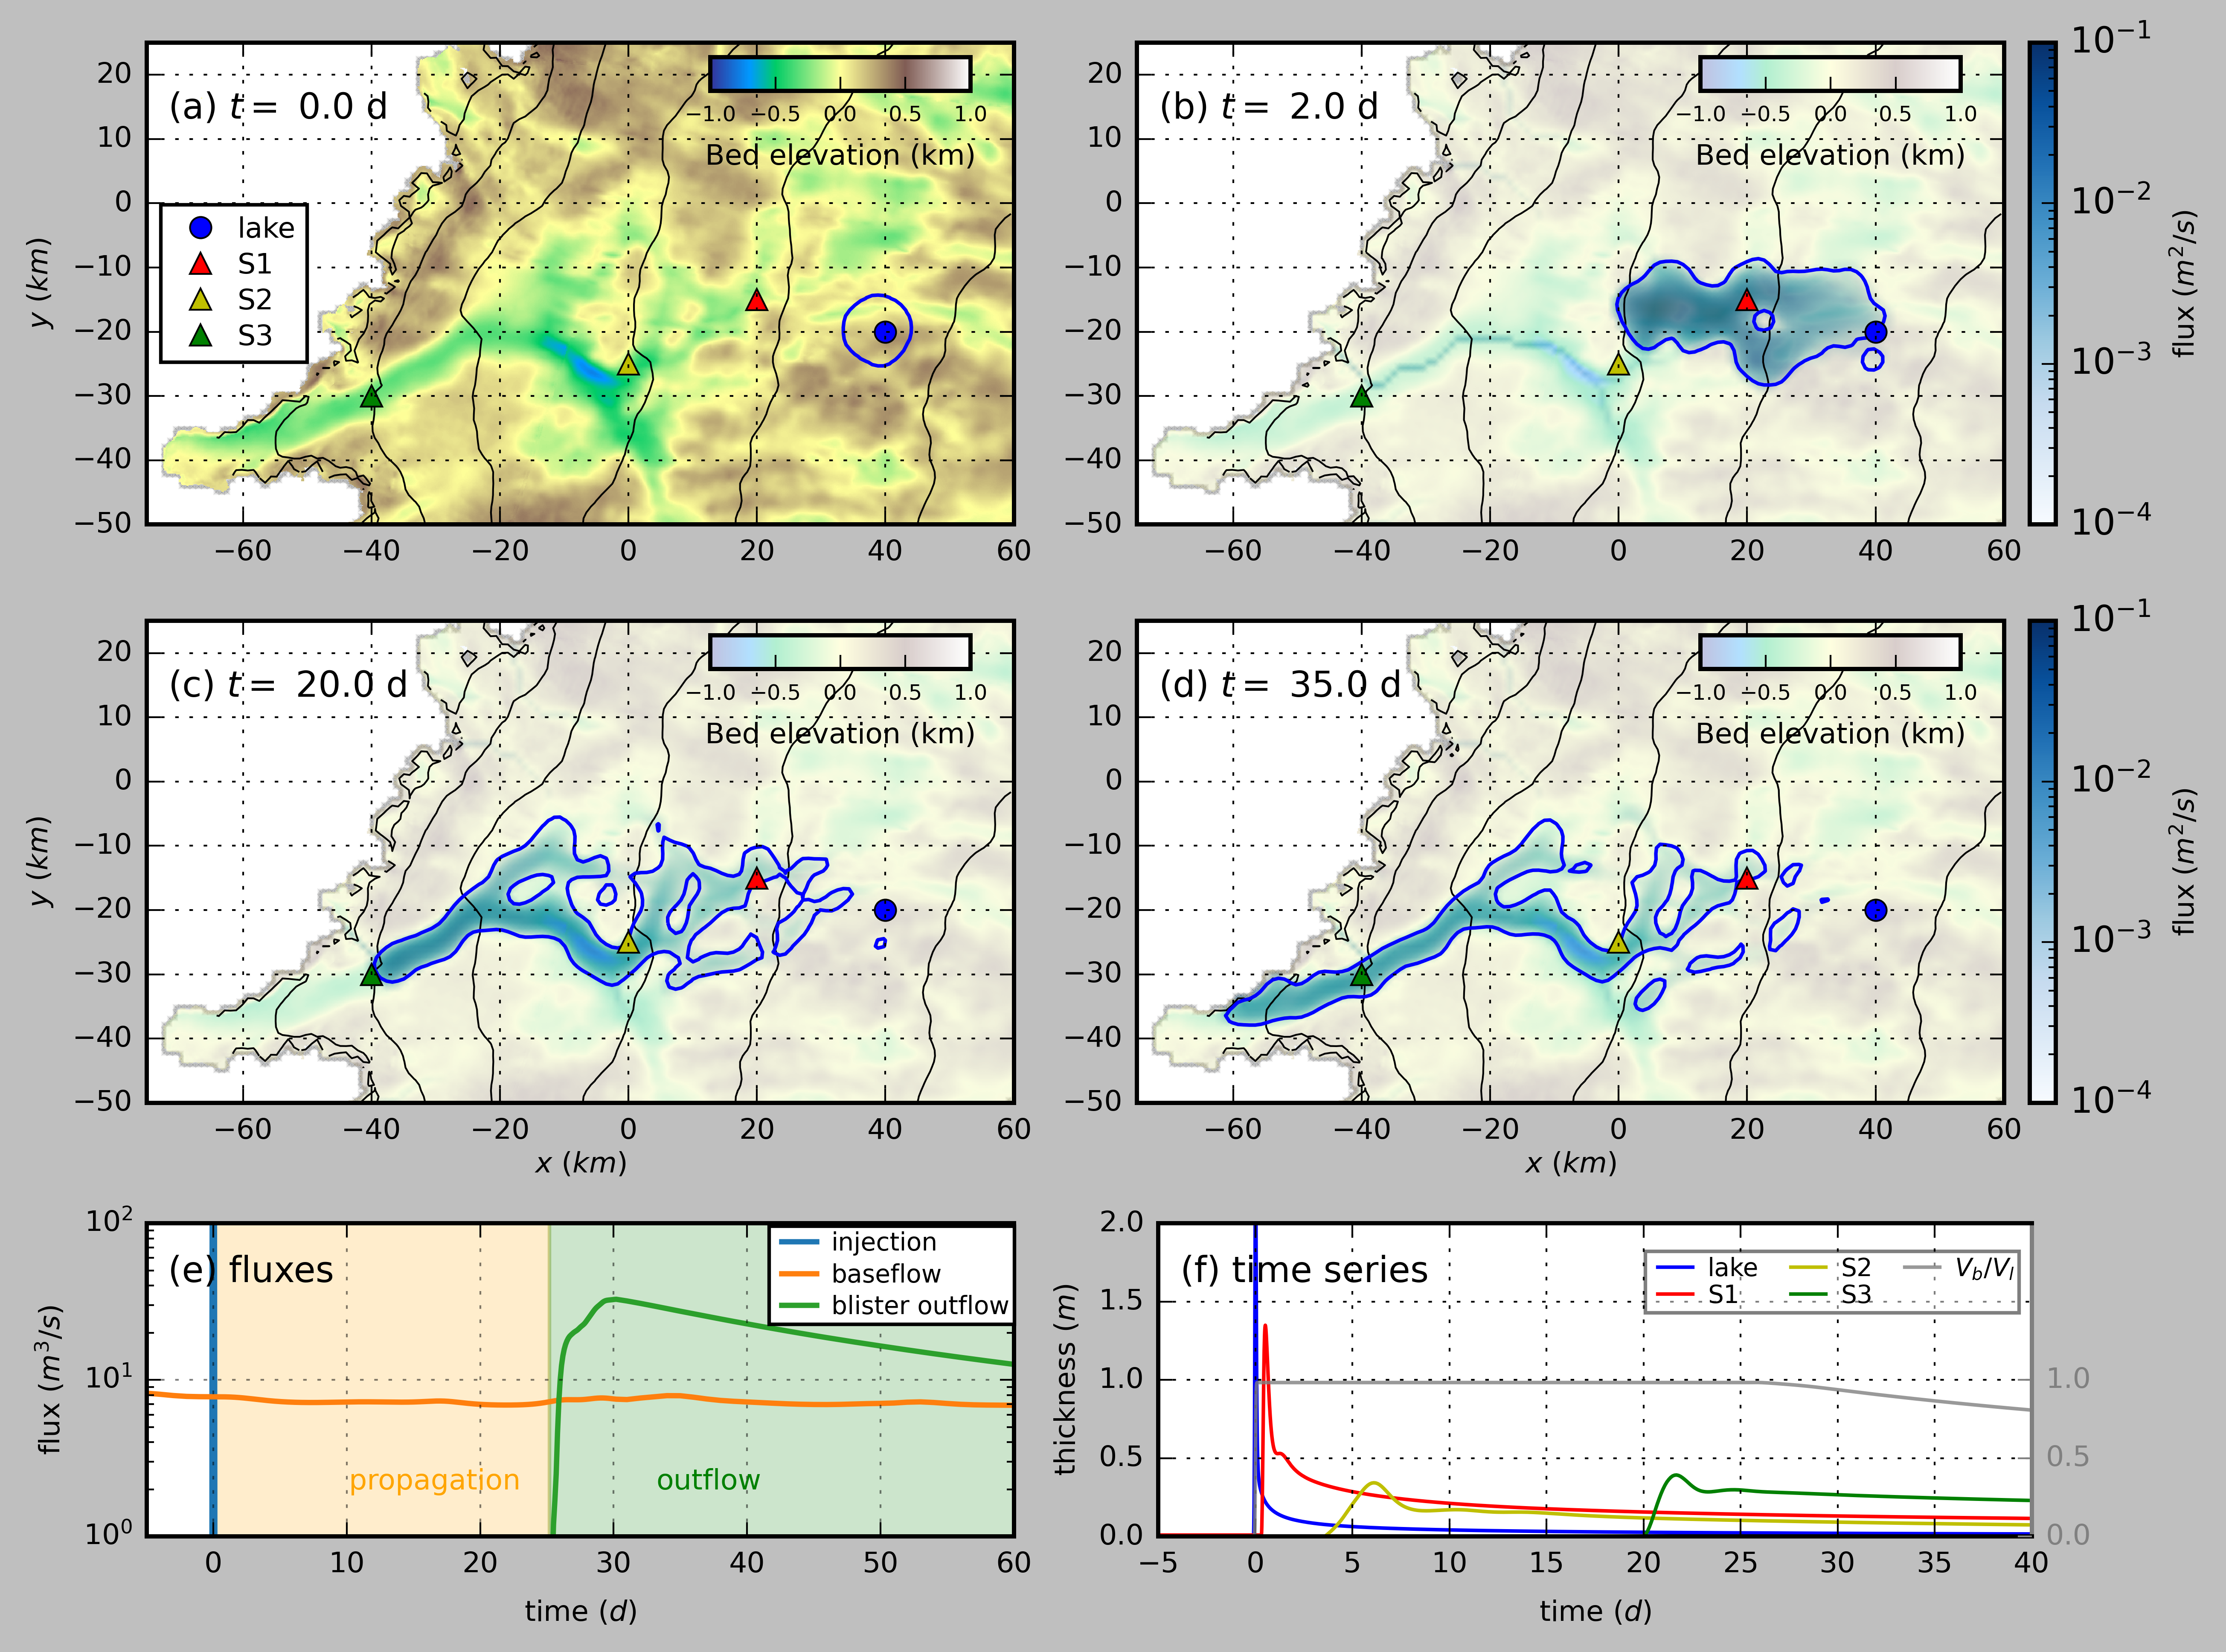

In [5]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
import subprocess

class NevisFig3Plotter:
    """
    A class to generate Figure 3 (summertime) plot for NEVIS simulation data.
    This class packs all the plotting code from the first cell into a single class.
    """
    
    def __init__(self, casename, results_dir='results', matlab_path="/Applications/MATLAB_R2025a.app/bin/matlab"):
        """
        Initialize the plotter with casename and paths.
        
        Args:
            casename: Name of the simulation case
            results_dir: Directory containing results
            matlab_path: Path to MATLAB executable
        """
        self.casename = casename
        self.results_dir = results_dir
        self.matlab_path = matlab_path
        
        # Flag to control data import
        self.SKIP_DATA_IMPORT = False
        self.LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
        
        # -------------------- Parameters for plotting ---------------------------------------------
        okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
                     "#0072B2","#D55E00","#CC79A7","#000000"]
        self.colors = okabe_ito
        self.colors = plt.get_cmap('tab10').colors  

        self.xa = -75
        self.xb = 60
        self.ya = -50
        self.yb = 25
        self.plot_hb = False
        self.plot_qs = True
        self.h_min = 0  # min water thickness on the color bar (m)
        self.h_max = 0.5  # max water thickness on the color bar (m)
        self.q_min = 1e-4  # min water flux on the color bar (m2/s)
        self.q_max = 1e-1  # max water flux on the color bar (
        # self.norm = PowerNorm(gamma=1, vmin=self.h_min, vmax=self.h_max)
        # self.norm = PowerNorm(gamma=1, vmin=self.q_min, vmax=self.q_max)
        self.norm = LogNorm(vmin=self.q_min, vmax=self.q_max)
        # self.norm = LogNorm(vmin=self.h_min, vmax=self.h_max)

        self.tdrainge_d = 30
        self.tmin = self.tdrainge_d - 5
        self.tmax = self.tdrainge_d + 40
        self.tmin_d = self.tmin 
        self.tmax_d = self.tmax
        self.tslice = self.tdrainge_d + np.array([0, 2, 20, 35])
        
        # Data containers
        self.data_loaded = False
        
    def load_terrain(self):
        """Load terrain data from file"""
        mat_path = os.path.join('./data/nevis_regional/morlighem_for_nevis_140km.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)
        morlighem_for_nevis_140km = raw['morlighem_for_nevis_140km']
        self.X_terrain = morlighem_for_nevis_140km['X_km'].item()
        self.Y_terrain = morlighem_for_nevis_140km['Y_km'].item()
        self.B_terrain = morlighem_for_nevis_140km['B_km'].item()
        self.S_terrain = morlighem_for_nevis_140km['S_km'].item()

    def load_data(self):
        """Load and process all data"""
        if (not self.SKIP_DATA_IMPORT) or (self.LOAD_NEW_DATA):
            print("Loading data...")
            # ------------------------- Import data -----------------------------------

            mat_path = os.path.join(self.results_dir, self.casename, self.casename + '.mat')
            raw = sio.loadmat(mat_path, squeeze_me=True)

            self.tt = raw['tt']
            self.ps = raw['ps']
            self.pp = raw['pp']
            self.oo = raw['oo']
            self.pd = raw['pd']
            self.aa = raw['aa']
            self.gg = raw['gg']
            self.aa = raw['aa']

            self.ps_t = np.float64(self.ps['t'])
            self.pd_td = np.float64(self.pd['td'])
            self.ps_hb = np.float64(self.ps['hb'])
            self.ps_h = np.float64(self.ps['h'])
            self.ps_x = np.float64(self.ps['x'])
            self.ps_z = np.float64(self.ps['z'])
            self.ps_m = np.float64(self.ps['m'])
            self.ps_S = np.float64(self.ps['S'])
            self.ps_phi = np.float64(self.ps['phi'])
            self.ps_Q0 = np.float64(self.ps['Q0'])
            self.ps_Q = np.float64(self.ps['Q'])
            self.ps_qs = np.float64(self.ps['qs'])
            self.ps_qb = np.float64(self.ps['qb'])

            self.pp_c8 = np.float64(self.pp['c8'])
            self.tt_t = np.float64(self.tt['t'])
            self.tt_Qb_in = np.float64(self.tt['Qb_in'])
            self.tt_Qb_dec = np.float64(self.tt['Qb_dec'])
            self.tt_Q_outb = np.float64(self.tt['Q_outb'])
            self.tt_Q_outQ = np.float64(self.tt['Q_outQ'])
            self.tt_Q_outq = np.float64(self.tt['Q_outq'])
            self.tt_E = np.float64(self.tt['E'])

            # --- Compute time vectors -----------------------------------------------
            self.t = (self.ps_t / (24*60*60)) * self.tt_t        # days

            # --- Build derived quantities -------------------------------------------
            self.Q_b_in = np.float64(self.pd['Q_0']) * self.tt_Qb_in
            self.Q_b_dec = self.ps_h * self.ps_x**2 / self.ps_t * self.tt_Qb_dec

            self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
            self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
            self.Q_out_Q = self.ps_Q * self.tt_Q_outQ
            self.Q_out_q = self.ps_Q * self.tt_Q_outq
            self.E = self.ps_m * self.ps_x**2 * self.tt_E

            self.pts_ni = np.int64(self.oo['pts_ni'].item())
            self.phi_0 = self.ps_phi * np.float64(self.aa['phi_0'].item())
            self.pts_phi_lake = self.ps_phi * np.array([np.float64(sub_arr[-1]) for sub_arr in self.tt['pts_phi']])
            self.pts_phi_moulin = self.ps_phi * np.array([np.float64(sub_arr[-2]) for sub_arr in self.tt['pts_phi']])
            self.pts_hb_lake = self.ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_moulin = self.ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_hb']])
            self.pts_pb_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_pb']])
            self.pts_hc_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hc']])
            self.pts_hs_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hs']])

            self.pts_hb_gps1 = self.ps_hb * np.array([np.float64(sub_arr[-1]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps2 = self.ps_hb * np.array([np.float64(sub_arr[-2]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps3 = self.ps_hb * np.array([np.float64(sub_arr[-3]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps4 = self.ps_hb * np.array([np.float64(sub_arr[-4]) for sub_arr in self.tt['pts_hb']])
            self.pts_hb_gps5 = self.ps_hb * np.array([np.float64(sub_arr[-5]) for sub_arr in self.tt['pts_hb']])

            self.pts_hc_gps1 = self.ps_h * np.array([np.float64(sub_arr[-1]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps2 = self.ps_h * np.array([np.float64(sub_arr[-2]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps3 = self.ps_h * np.array([np.float64(sub_arr[-3]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps4 = self.ps_h * np.array([np.float64(sub_arr[-4]) for sub_arr in self.tt['pts_hc']])
            self.pts_hc_gps5 = self.ps_h * np.array([np.float64(sub_arr[-5]) for sub_arr in self.tt['pts_hc']])

            self.pts_hs_gps1 = self.ps_h * np.array([np.float64(sub_arr[-1]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps2 = self.ps_h * np.array([np.float64(sub_arr[-2]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps3 = self.ps_h * np.array([np.float64(sub_arr[-3]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps4 = self.ps_h * np.array([np.float64(sub_arr[-4]) for sub_arr in self.tt['pts_hs']])
            self.pts_hs_gps5 = self.ps_h * np.array([np.float64(sub_arr[-5]) for sub_arr in self.tt['pts_hs']])

            self.N = self.ps_phi * np.float64(self.tt['N'])  # MPa
            self.pts_N_lake = np.float64(self.phi_0[self.pts_ni][-1] - self.pts_phi_lake)
            self.pts_N_moulin = np.float64(self.phi_0[self.pts_ni][1] - self.pts_phi_moulin)

            self.V_b = self.ps_x**2 * self.ps_hb * np.float64(self.tt['Vb'])
            self.V_c = self.ps_x * self.ps_S * np.float64(self.tt['S'])
            self.V_s = self.ps_x**2 * self.ps_h * np.float64(self.tt['hs'])
            self.R_b = self.ps_x * np.float64(self.tt['Rb'])

            self.xx = self.ps_x/1e3 * np.float64(self.gg['nx'].item())
            self.yy = self.ps_x/1e3 * np.float64(self.gg['ny'].item())
            self.nI = int(self.gg['nI'].item())
            self.nJ = int(self.gg['nJ'].item())
            self.eI = int(self.gg['eI'].item())
            self.eJ = int(self.gg['eJ'].item())
            self.cI = int(self.gg['cI'].item())
            self.cJ = int(self.gg['cJ'].item())

            self.nmeanx = self.gg['nmeanx'].item()
            self.nmeany = self.gg['nmeany'].item()
            self.nmeans = self.gg['nmeans'].item()
            self.nmeanr = self.gg['nmeanr'].item()
            self.ein = self.gg['ein'].item()
            self.fin = self.gg['fin'].item()
            self.cin = self.gg['cin'].item()
            self.Dx = np.float64(self.gg['Dx'].item())
            self.Dy = np.float64(self.gg['Dy'].item())
            self.Ds = np.float64(self.gg['Ds'].item())
            self.Dr = np.float64(self.gg['Dr'].item())

            # auxiliary fields
            H_val = np.float64(self.aa['H'].item())
            self.H = np.array(np.reshape(H_val, (self.nI, self.nJ), order='F'), dtype=np.float64)

            # --- get spatial pattern at different times -----------------------------
            tspan = self.ps_t/self.pd_td*self.oo['t_span']
            self.nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in self.tslice])

            # run matlab script to extend the field for times
            filenames = [os.path.join(self.results_dir, self.casename, f"{num:04d}.mat") for num in self.nums]
            print(f"Processing files: {filenames}")
            # save the filenames to a text file
            # Save filenames and casename to a .mat file for MATLAB to load
            filenames_array = np.array(filenames, dtype=object)
            sio.savemat('extend_field.mat', {
                'filenames': filenames_array,
                'casename': self.casename
            })
            # Use MATLAB's -batch option to run the script and auto‐exit when done
            subprocess.run([
                self.matlab_path,
                "-nodisplay",
                "-nosplash",
                "-nodesktop",
                "-batch",
                "run('src/nevis_nodedischarge_python')"
            ], check=True)
            # Clear the temporary .mat file
            os.remove('extend_field.mat')

            self.vhb = []
            self.vphi1 = []
            self.vhs = []
            self.vhc = []
            self.vt = []
            self.vqs = []
            self.vqe = []
            self.vqQ = []
            self.vqb = []

            for i in range(len(self.nums)):
                con_path = os.path.join(self.results_dir, self.casename, f"{self.nums[i]:04d}.mat")
                raw_con = sio.loadmat(con_path, squeeze_me=True)
                vv = raw_con['vv']
                vv2 = raw_con['vv2']

                # geometry values
                phi1_val = np.float64(vv['phi'].item())
                hb_val = np.float64(vv['hb'].item())
                hs_val = np.float64(vv['hs'].item())
                pb_val = np.float64(vv['pb'].item())

                Sx_val = self.nmeanx.dot(np.float64(vv['Sx'].item()))
                Sy_val = self.nmeany.dot(np.float64(vv['Sy'].item()))
                Ss_val = self.nmeans.dot(np.float64(vv['Ss'].item()))
                Sr_val = self.nmeanr.dot(np.float64(vv['Sr'].item()))

                self.vphi1.append(np.array(np.reshape(phi1_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vhb.append(np.array(np.reshape(hb_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                vpb = np.array(np.reshape(pb_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                self.vhs.append(np.array(np.reshape(hs_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                vSx = np.array(np.reshape(Sx_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSy = np.array(np.reshape(Sy_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSs = np.array(np.reshape(Ss_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                vSr = np.array(np.reshape(Sr_val, (self.nI, self.nJ), order='F'), dtype=np.float64)
                self.vhc.append(np.reshape(self.pp_c8*(Sx_val*self.Dx + Sy_val*self.Dy + Ss_val*self.Ds + Sr_val*self.Dr)/(self.Dx*self.Dy), (self.nI, self.nJ), order='F'))
                self.vt.append((self.ps_t / self.pd_td) * np.float64(vv['t'].item()))

                # flux values
                qs_val = np.float64(vv2['qs'].item())
                qe_val = np.float64(vv2['qe'].item())
                qQ_val = np.float64(vv2['qQ'].item())
                qb_val = np.float64(vv2['qb'].item())
                self.vqs.append(np.array(np.reshape(qs_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqe.append(np.array(np.reshape(qe_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqQ.append(np.array(np.reshape(qQ_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
                self.vqb.append(np.array(np.reshape(qb_val, (self.nI, self.nJ), order='F'), dtype=np.float64))
            self.vt = np.array(self.vt, dtype=np.float64)-self.tdrainge_d
            
            self.data_loaded = True
            print("Data loading completed")

    def setup_plotting_style(self):
        """Set up all matplotlib plotting styles"""
        # ================= Plotting setup ======================================
        plt.style.use('classic')
        plt.rc('axes', prop_cycle=cycler('color', self.colors))
        plt.rcParams["figure.dpi"] = 600
        # plt.style.use('classic')
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['mathtext.fontset'] = 'dejavusans'
        plt.rcParams['font.size'] = 8
        plt.rcParams['axes.linewidth'] = 1.2

    def plot_spatial_panel(self, ax, panel_idx, panel_label, add_colorbar=False):
        """Plot a single spatial panel"""
        cmap = plt.cm.Blues
        from matplotlib.colors import TwoSlopeNorm
        if add_colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.1)
        
        if self.plot_hb:
            pc = ax.pcolormesh(self.xx, self.yy,
                            self.ps_hb * self.vhb[panel_idx] + self.ps_h * self.vhs[panel_idx] + self.ps_h * self.vhc[panel_idx],
                            cmap=cmap, norm=self.norm, shading='gouraud')
            pc.set_edgecolor('face')
            
        elif self.plot_qs:
            pc = ax.pcolormesh(self.xx, self.yy,
                            self.ps_qs * self.vqs[panel_idx] + self.ps_qb * self.vqb[panel_idx] + self.ps_qs * self.vqQ[panel_idx],
                            cmap=cmap, norm=self.norm, shading='gouraud')
            pc.set_edgecolor('face')
        else:
            print("No valid plot type selected. Please set plot_hb or plot_qs to True.")
            return ax

        # Add the thickness map self.H*ps.z as the background
        norm = PowerNorm(gamma=1, vmin=-1.0, vmax=1.0)
        if panel_idx == 0:
            terrain = ax.pcolormesh(self.X_terrain/1e3, self.Y_terrain/1e3, self.B_terrain/1e3 + 0.0*(self.S_terrain-self.B_terrain)/1e3, norm=norm, cmap='terrain', alpha=1.0)
        else:
            terrain = ax.pcolormesh(self.X_terrain/1e3, self.Y_terrain/1e3, self.B_terrain/1e3 + 0.0*(self.S_terrain-self.B_terrain)/1e3, norm=norm, cmap='terrain', alpha=0.3)

        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cbax = inset_axes(ax,
                 width="30%",   
                 height="7%",  
                 loc='lower left',
                 bbox_to_anchor=(0.65, 0.90, 1.0, 1.0),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
        cbar_terr = plt.colorbar(terrain, cax=cbax, orientation='horizontal')
        cbar_terr.set_label('Bed elevation (km)')
        cbar_terr.set_ticks(np.array([-1.0, -0.5, 0.0, 0.5, 1.0]))
        cbar_terr.ax.tick_params(labelsize=6)

        # Plot contour lines for the blister alone
        # contour_lines = ax.contour(self.xx, self.yy, self.ps_hb * self.vhb[panel_idx], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
        contour_lines = ax.contour(self.xx, self.yy, self.ps_phi/1e6*self.vphi1[panel_idx],
                       colors='k', linewidths=0.5, linestyles='-', label='Contour lines')
        
        ax.contour(
            self.xx, self.yy,
            self.ps_hb * self.vhb[panel_idx],
            levels=[0.1],
            colors='blue',
            linewidths=1.0,
            linestyles='-'
        )

        # Add markers and labels only for first panel
        if panel_idx == 0:
            ax.plot(40, -20, 'bo', markersize=6, label='lake')
            # ax.plot(40, -5, 'r^', markersize=6, label='GPS1')
            ax.plot(20, -15, 'r^', markersize=6, label='S1')
            ax.plot(0, -25, 'y^', markersize=6, label='S2')
            ax.plot(-40, -30, 'g^', markersize=6, label='S3')
        else:
            ax.plot(40, -20, 'bo', markersize=6)
            # ax.plot(40, -5, 'r^', markersize=6)
            ax.plot(20, -15, 'r^', markersize=6)
            ax.plot(0, -25, 'y^', markersize=6)
            ax.plot(-40, -30, 'g^', markersize=6)

        if add_colorbar:
            cbar = plt.colorbar(pc, cax=cax, orientation='vertical')
            cbar.set_label('thickness$\\;(m)$' if self.plot_hb else 'flux$\\;(m^2/s)$')
            cbar.ax.tick_params(labelsize=10)
            from matplotlib.ticker import ScalarFormatter
            # formatter = ScalarFormatter(useMathText=True)
            # formatter.set_scientific(True)
            # formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
            # cbar.ax.yaxis.set_major_formatter(formatter)
            # cbar.ax.tick_params(labelsize=10)

        ax.text(0.025, 0.9, f'{panel_label} $t=$ ${self.vt[panel_idx]:.1f}$ d', transform=ax.transAxes,
                ha='left', va='top', fontsize=10, clip_on=False, color='black')
        ax.set_xlim(self.xa, self.xb)
        ax.set_ylim(self.ya, self.yb)
        ax.set_aspect('equal')
        ax.grid()
        if panel_idx == 0:
            ax.legend(loc='center left', fontsize=8, frameon=True, 
                    handletextpad=0.3, ncol=1, labelspacing=0.3, numpoints=1)
        # else:
            # ax.legend(loc='lower right', fontsize=8, frameon=True, 
            #         handletextpad=0.3, ncol=2, labelspacing=0.3, numpoints=1)
        return ax

    def generate_figure(self, save_path=None):
        """Generate the complete Figure 3 plot"""
        if not self.data_loaded:
            self.load_data()
            
        self.setup_plotting_style()
        
        self.load_terrain()
        fig = plt.figure(figsize=(10, 8), dpi=300)
        gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.05, hspace=0.2)

        # ================= Panel (a): blister at time a =================
        ax1 = fig.add_subplot(gs[0, 0])
        self.plot_spatial_panel(ax1, 0, '(a)')
        ax1.set_ylabel('$y~(km)$')

        # ================= Panel (b): blister at time b ================
        ax2 = fig.add_subplot(gs[0, 1])
        self.plot_spatial_panel(ax2, 1, '(b)', add_colorbar=True)

        # ================= Panel (c): blister at time c ================
        ax3 = fig.add_subplot(gs[1, 0])
        self.plot_spatial_panel(ax3, 2, '(c)')
        ax3.set_xlabel('$x~(km)$')
        ax3.xaxis.set_label_coords(0.5, -0.1)
        ax3.set_ylabel('$y~(km)$')

        # ================= Panel (d): blister at time d ================
        ax4 = fig.add_subplot(gs[1, 1])
        self.plot_spatial_panel(ax4, 3, '(d)', add_colorbar=True)
        ax4.set_xlabel('$x~(km)$')
        ax4.xaxis.set_label_coords(0.5, -0.1)

        # ============== Panel (e): Flux (last row: spanning both columns) ==============
        # Panel (e) — combined h/S at the lake (bottom merged)
        ax5 = fig.add_subplot(gs[2, 0])
        ax5.set_visible(False)  # Hide original axes

        # Get positions of the axes above to align with
        pos_left = ax3.get_position()
        pos_right = ax4.get_position()
        pos_bottom = gs[2, :].get_position(fig)

        # Compute full available width
        full_width = pos_left.x1 - pos_left.x0

        # Shrink factor (e.g. 70% of full width)
        shrink_factor = 1
        ax5_width = full_width * shrink_factor

        # Center the shrunken panel horizontally
        ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
        ax5_pos = [ax5_x0, pos_bottom.y0+0.3*pos_bottom.height, ax5_width, 0.65*pos_bottom.height]

        # Create new axes with the calculated positions
        ax5 = fig.add_axes(ax5_pos)

        ax5.plot(self.t-self.tdrainge_d, self.Q_b_in, '-', linewidth=1.5, label='injection')
        # ax5.plot(self.t-self.tdrainge_d, self.Q_b_dec,'-', linewidth=1.0, label='leakage')
        ax5.plot(self.t-self.tdrainge_d, 0*self.Q_out_q+self.Q_out_Q, '-', linewidth=1.5, label='baseflow')
        ax5.plot(self.t-self.tdrainge_d, self.Q_out_b, '-', linewidth=1.5, label='blister outflow')

        drainage_start_ind = np.where(self.Q_b_in > 1e-6)[0][0]
        drainage_end_ind = np.where(self.Q_b_in > 1e-6)[0][-1]
        # check if empty
        if np.where(self.Q_out_b > 1e-1)[0].size > 0:
            reaching_boundary_ind = np.where(self.Q_out_b > 1e-1)[0][0]
        else:
            reaching_boundary_ind = 0

        ax5.axvspan(self.t[drainage_start_ind]-self.tdrainge_d, self.t[drainage_end_ind]-self.tdrainge_d, color='blue', alpha=0.2)
        ax5.axvspan(self.t[drainage_end_ind]-self.tdrainge_d, self.t[reaching_boundary_ind]-self.tdrainge_d, color='orange', alpha=0.2)
        # ax5.text(self.t[drainage_start_ind]-self.tdrainge_d-2, 2e0, 'drainage', color='blue', fontsize=8)
        ax5.text(self.t[drainage_end_ind]-self.tdrainge_d+10, 2e0, 'propagation', color='orange', fontsize=8)
        ax5.text(self.t[reaching_boundary_ind]-self.tdrainge_d+8, 2e0, 'outflow', color='green', fontsize=8)
        
        ax5.axvspan(self.t[reaching_boundary_ind]-self.tdrainge_d, self.tmax_d, color='green', alpha=0.2)

        ax5.set_yscale('log')
        ax5.set_xlim(self.tmin_d-self.tdrainge_d, self.tmax_d-self.tdrainge_d+10)
        ax5.set_xlabel('time$~(d)$')
        ax5.xaxis.set_label_coords(0.5, -0.2)
        ax5.set_ylim(1e0, 1e2 )
        ax5.set_xlim(-5, 60)
        ax5.set_ylabel('flux$~(m^3/s)$')
        ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
                ha='left', va='top', fontsize=10, clip_on=False)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.015, 1.03), frameon=True, fontsize=7, ncol=1,
                  labelspacing=0.3, handletextpad=0.3, borderpad=0.2)
        ax5.grid(alpha=0.5)

        # ============== Panel (f): total volume and thickness ==============
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.set_visible(False)  # Hide original axes

        # Get positions of the axes above to align with
        pos_right = ax4.get_position()
        pos_bottom = gs[2, 1].get_position(fig)

        # Compute full available width
        full_width = pos_right.x1 - pos_right.x0

        # Shrink factor (e.g. 70% of full width)
        shrink_factor = 0.95
        ax6_width = full_width * shrink_factor

        # Center the shrunken panel horizontally
        ax6_x0 = pos_right.x0 + 0.05*ax6_width
        ax6_pos = [ax6_x0, pos_bottom.y0+0.3*pos_bottom.height, ax6_width*0.95, 0.65*pos_bottom.height]

        # Colorbar axes to the right of the shrunken panel
        pad = 0.01
        colorbar_width = 0.015
        cax_pos = [ax6_x0 + ax6_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

        # Create new axes with the calculated positions
        ax6 = fig.add_axes(ax6_pos)
        # ============== Plot thickness ==============
        ax6.plot(self.t-self.tdrainge_d,\
                self.ps_hb*self.pts_hb_lake + 0*self.ps_h*(self.pts_hc_gps1+self.pts_hs_gps1),\
                'b-', linewidth=1.0, label='lake', alpha=1.0)
        # ax6.plot(self.t-self.tdrainge_d,\
        #         self.ps_hb*self.pts_hb_gps4 + 0*self.ps_h*(self.pts_hc_gps4+self.pts_hs_gps4),\
        #         'r-', linewidth=1.0, label='GPS1', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d,\
                self.ps_hb*self.pts_hb_gps3 + 0*self.ps_h*(self.pts_hc_gps3+self.pts_hs_gps3),\
                'r-', linewidth=1.0, label='S1', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d,\
                self.ps_hb*self.pts_hb_gps2 + 0*self.ps_h*(self.pts_hc_gps2+self.pts_hs_gps2),\
                'y-', linewidth=1.0, label='S2', alpha=1.0)
        ax6.plot(self.t-self.tdrainge_d,\
                self.ps_hb*self.pts_hb_gps1 + 0*self.ps_h*(self.pts_hc_gps1+self.pts_hs_gps1),\
                'g-', linewidth=1.0, label='S3', alpha=1.0)
        
        # ax6.plot(self.t-self.tdrainge_d,\
        #         self.ps_hb*self.pts_hb_gps5 + self.ps_h*(self.pts_hc_gps5+self.pts_hs_gps5),\
        #         'y-', linewidth=1.0, label='GPS5', alpha=1.0)

        ax6.set_xlabel('time$~(d)$')   
        ax6.xaxis.set_label_coords(0.5, -0.2)
        ax6.set_ylim(0, 2.0)
        ax6.set_xlim(-5, 40)
        ax6.set_ylabel(r'thickness$~(m)$')
        ax6.text(0.025, 0.9, '(f) time series', transform=ax6.transAxes,
                ha='left', va='top', fontsize=10, clip_on=False)
        ax6.grid(alpha=1.0)

        # ============== Plot volume ==============
        ax6_twin = ax6.twinx()
        ax6_twin.plot(self.t-self.tdrainge_d, self.V_b/(1.8e8), '-', color='grey', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
        # ax6_twin.plot(self.t-self.tdrainge_d, self.R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

        ax6_twin.set_xlabel('time$~(d)$')
        ax6_twin.set_ylim(0, 2.0)
        ax6_twin.set_yticks([0, 0.5, 1.0])
        ax6_twin.tick_params(axis='y', labelsize=8)
        # ax6_twin.grid(alpha=0.5)
        # make axis and label blue
        ax6_twin.spines['right'].set_color('grey')
        ax6_twin.yaxis.label.set_color('grey')
        ax6_twin.tick_params(axis='y', colors='grey')

        # combine legend entries from ax6 and its twin
        handles1, labels1 = ax6.get_legend_handles_labels()
        handles2, labels2 = ax6_twin.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right',
            bbox_to_anchor=(1.0, 0.95), fontsize=7, ncol=3,
            labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
            frameon=True, framealpha=0.5)

        if save_path:
            fig.savefig(save_path, dpi=600, transparent=False, bbox_inches='tight', pad_inches=0.1)
            print(f"Figure saved to {save_path}")
        
        return fig
    
# Example usage:
if __name__ == "__main__":
    # casename = 'n2d_region_test_meanperms1_Hreg1000_kappa1e_99_mu2e1_spinup'
    casename = 'n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu2e1_td30_V1e8_drainage'
    plotter = NevisFig3Plotter(casename)
    fig1 = plotter.generate_figure(save_path='./figures/Fig7_regional_poster.png')#
 

Case n2d_region_melt_meanperms1_Hreg1000_kappa1e_10_mu1e1_td30_V1e8_drainage: t_Qout = 90.00 days
Case n2d_region_melt_meanperms1_Hreg1000_kappa1e_11_mu1e1_td30_V1e8_drainage: t_Qout = 90.00 days
Case n2d_region_melt_meanperms1_Hreg1000_kappa5e_12_mu1e1_td30_V1e8_drainage: t_Qout = 21.10 days
Case n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu1e1_td30_V1e8_drainage: t_Qout = 12.50 days


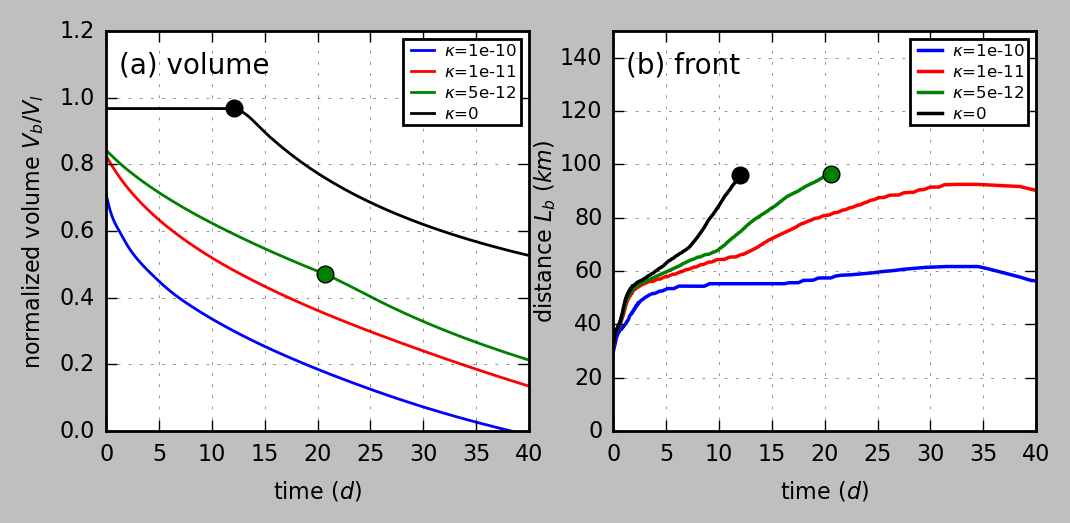

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio

class NevisRegionalCaseAnalyzer:
    """
    A class for loading and analyzing NEVIS .mat result files.

    This class can process one or more casenames, calculate the front propagation speed
    for each case, and store the results for later use.
    """
    def __init__(self, results_dir='results'):
        """
        Initialize the analyzer.

        Args:
            results_dir (str): Root directory containing casename result folders.
        """
        self.results_dir = results_dir
        self.results = {}

    def _load_and_process_case(self, casename):
        """
        Load and process data for a single case.
        """
        mat_path = os.path.join(self.results_dir, casename, f"{casename}.mat")
        try:
            raw = sio.loadmat(mat_path, squeeze_me=True)
        except FileNotFoundError:
            print(f"Warning: File not found {mat_path}, skipping this case.")
            return None

        # Extract data
        tt = raw['tt']
        ps = raw['ps']
        
        # Type conversion
        ps_x = np.float64(ps['x'])
        ps_t = np.float64(ps['t'])
        ps_hb = np.float64(ps['hb'])
        
        # Calculate derived quantities
        t = (ps_t / (24 * 60 * 60)) * np.float64(tt['t'])
        # Core analysis logic
        L_bx = np.abs(ps_x * np.float64(tt['Lbx']) - 40e3)
        L_by = np.abs(ps_x * np.float64(tt['Lby']) + 15e3)
        L_b = np.sqrt(L_bx**2 + L_by**2)
        # L_b = L_bx
        V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
        Q_b_out = np.float64(tt['Q_outb'])
        return t, L_bx, L_by, L_b, V_b, Q_b_out

    def run_analysis(self, casenames):
        """
        Run analysis for a list of casenames.
        """
        vt = []
        Lbx = []
        Lby = []
        Lb = []
        Vb = []
        Q_out_b = []
        for casename in casenames:
            result = self._load_and_process_case(casename)
            if result is not None:
                t, L_bx, L_by, L_b, V_b, Q_b_out = result
                vt.append(t)
                Lbx.append(L_bx)
                Lby.append(L_by)
                Lb.append(L_b)
                Vb.append(V_b)
                Q_out_b.append(Q_b_out)

        return vt, Lbx, Lby, Lb, Vb, Q_out_b

fontsize_panel = 9

casenames = ['n2d_region_test_meanperms1_Hreg1000_kappa1e_10_mu1e1_spinup',\
             'n2d_region_test_meanperms1_Hreg1000_kappa1e_11_mu1e1_spinup',\
             'n2d_region_test_meanperms1_Hreg1000_kappa5e_12_mu1e1_spinup',\
             'n2d_region_test_meanperms1_Hreg1000_kappa1e_99_mu1e1_spinup']

casenames = ['n2d_region_melt_meanperms1_Hreg1000_kappa1e_10_mu1e1_td30_V1e8_drainage',\
             'n2d_region_melt_meanperms1_Hreg1000_kappa1e_11_mu1e1_td30_V1e8_drainage',\
             'n2d_region_melt_meanperms1_Hreg1000_kappa5e_12_mu1e1_td30_V1e8_drainage',\
             'n2d_region_melt_meanperms1_Hreg1000_kappa1e_99_mu1e1_td30_V1e8_drainage']

vkappa = [1e-10, 1e-11, 5e-12, 0]
vmu = [10, 10, 10, 10]
# ================= Plotting setup ======================================
fig,ax = plt.subplots(1,2,figsize=(6, 2.5), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 8  
plt.rcParams['xtick.labelsize'] = 8 
plt.rcParams['ytick.labelsize'] = 8 
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

t_drainage = 30
analyzer = NevisRegionalCaseAnalyzer()
vt, Lbx, Lby, Lb, Vb, Q_out_b = analyzer.run_analysis(casenames)
colors = ['b', 'r', 'g', 'k']
t_Qout = []
for i in range(len(casenames)):
     # find time when Q_out_b first exceeds 0.1 m3/s
    Q = Q_out_b[i]
    idx = np.where(Q > 1e-3)[0]
    
    if len(idx) == 0:
        t_Qout.append(vt[i][-1]-t_drainage)
    else:
        t_Qout.append(vt[i][idx[0]]-t_drainage)
    print(f"Case {casenames[i]}: t_Qout = {t_Qout[i]:.2f} days")


# ================= Panel (a): Volume versus time =================
ax = plt.subplot(121)
for i in range(len(casenames)):
    Vb[i] = np.where((vt[i] < t_drainage), np.nan, Vb[i])
    ax.plot(vt[i]-t_drainage-0.5, Vb[i]/1.8e8,linestyle='-', linewidth=1.0, color=colors[i], label=r'$\kappa$='+str(vkappa[i]))
    valid_indices = np.where(vt[i]>t_Qout[i]+t_drainage)[0]
    if len(valid_indices) > 0:
        last_valid_index = valid_indices[0]
        ax.plot(vt[i][last_valid_index]-t_drainage-0.5, Vb[i][last_valid_index]/1.8e8, 'o', color=colors[i], markersize=6)

ax.set_xlim(0, 40)
ax.set_ylim(0, 1.2)
plt.legend(loc='upper right', fontsize=6, frameon=True, ncol=1,
          labelspacing=0.3, handletextpad=0.3, borderpad=0.2)
ax.set_xlabel('time$~(d)$')
ax.set_ylabel('normalized volume $V_b/V_l$')
ax.text(0.03, 0.95, '(a) volume', transform=ax.transAxes,
        ha='left', va='top', fontsize=fontsize_panel+1, clip_on=False)
ax.grid(alpha=0.5)

# ================= Panel (b): Front position versus time =================
ax = plt.subplot(122)
for i in range(len(casenames)):
    # smooth Lb with a moving average filter of window size 5
    window_size = 5
    Lb[i] = np.convolve(Lb[i], np.ones(window_size)/window_size, mode='same')
    idx = np.where(Vb[i] > 0.9*1.8e8)[0]
    Lb[i] = np.where((vt[i] < t_drainage+0.5) | (vt[i] > t_Qout[i] + t_drainage), np.nan, Lb[i])
    # print(f"Case {casenames[i]}: Front reaches 90% volume at t = {vt[i][idx[0]]} days")
    ax.plot(vt[i]-t_drainage-0.5, (Lb[i])/1e3,linestyle='-', linewidth=1.25, color=colors[i], label=r'$\kappa$='+str(vkappa[i]))

    # plot a circle at the last valid point
    valid_indices = np.where(~np.isnan(Lb[i]))[0]
    if len(valid_indices) > 0:
        last_valid_index = valid_indices[-1]
        ax.plot(vt[i][last_valid_index]-t_drainage-0.5, Lb[i][last_valid_index]/1e3, 'o', color=colors[i], markersize=6)

ax.set_xlim(0, 40)
ax.set_ylim(0, 150)
plt.legend(loc='upper right', fontsize=6, frameon=True, ncol=1,
          labelspacing=0.3, handletextpad=0.3, borderpad=0.2)
ax.set_xlabel('time$~(d)$')
ax.set_ylabel(r'distance $L_b~(km)$')
ax.yaxis.set_label_coords(-0.13, 0.5)

ax.text(0.03, 0.95, '(b) front', transform=ax.transAxes,
        ha='left', va='top', fontsize=fontsize_panel+1, clip_on=False)
ax.grid(alpha=0.5)

# from matplotlib.patches import FancyArrowPatch
# arrow = FancyArrowPatch((15, 100), (30, 40),
#                        arrowstyle='->', mutation_scale=10, 
#                        color='grey', linewidth=1.5, alpha=0.7)
# ax.add_patch(arrow)
# ax.text(20, 30, 'increasing leakage', rotation=0, va='center', fontsize=8)

plt.savefig('./figures/Fig8_regional_front_volume_poster.png', dpi=600, transparent=False, bbox_inches='tight', pad_inches=0.1)